In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from lightgbm import LGBMRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e25/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s3e25/test.csv")

In [3]:
train_df.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [4]:
train_df.describe()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.00000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,5203.00000,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,3004.38646,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2601.50000,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,5203.00000,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,7804.50000,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,10406.00000,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


Text(0.5, 1.0, 'Histogram of Column')

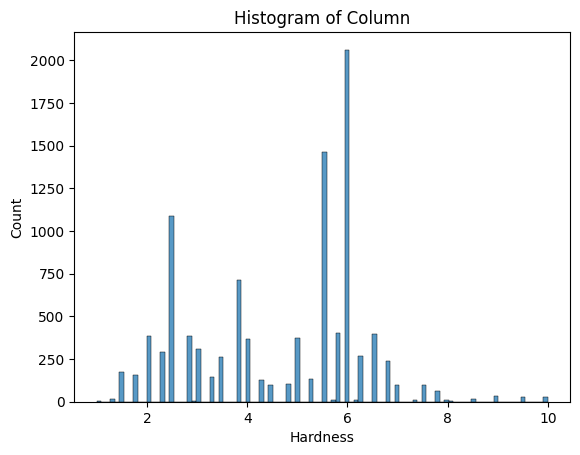

In [5]:
sns.histplot(data=train_df, x='Hardness', bins=100, kde=False)  # You can adjust the number of bins as needed
plt.title('Histogram of Column')

In [6]:
train_df["Hardness"].unique()

array([ 6.  ,  6.5 ,  2.5 ,  2.  ,  4.  ,  5.8 ,  5.5 ,  3.5 ,  4.5 ,
        3.8 ,  3.3 ,  5.  ,  6.3 ,  2.8 ,  3.  ,  1.8 ,  2.3 ,  7.  ,
        7.3 ,  7.5 , 10.  ,  5.3 ,  8.5 ,  4.3 ,  4.8 ,  6.8 ,  7.8 ,
        1.5 ,  1.3 ,  9.  ,  2.9 ,  8.  ,  6.2 ,  5.75,  9.5 ,  2.1 ,
        9.8 ,  8.1 ,  6.4 ,  4.7 ,  1.  ,  4.1 ,  3.2 ,  2.2 ,  8.3 ,
        3.6 ,  2.6 ,  6.7 ,  5.4 ,  6.64])

In [7]:
correlations = train_df.drop(columns=['id']).corr()
print(correlations["Hardness"])

allelectrons_Total      -0.061687
density_Total           -0.161524
allelectrons_Average    -0.400496
val_e_Average            0.161715
atomicweight_Average    -0.402948
ionenergy_Average        0.203203
el_neg_chi_Average       0.290352
R_vdw_element_Average   -0.061402
R_cov_element_Average   -0.189111
zaratio_Average          0.055248
density_Average         -0.360780
Hardness                 1.000000
Name: Hardness, dtype: float64


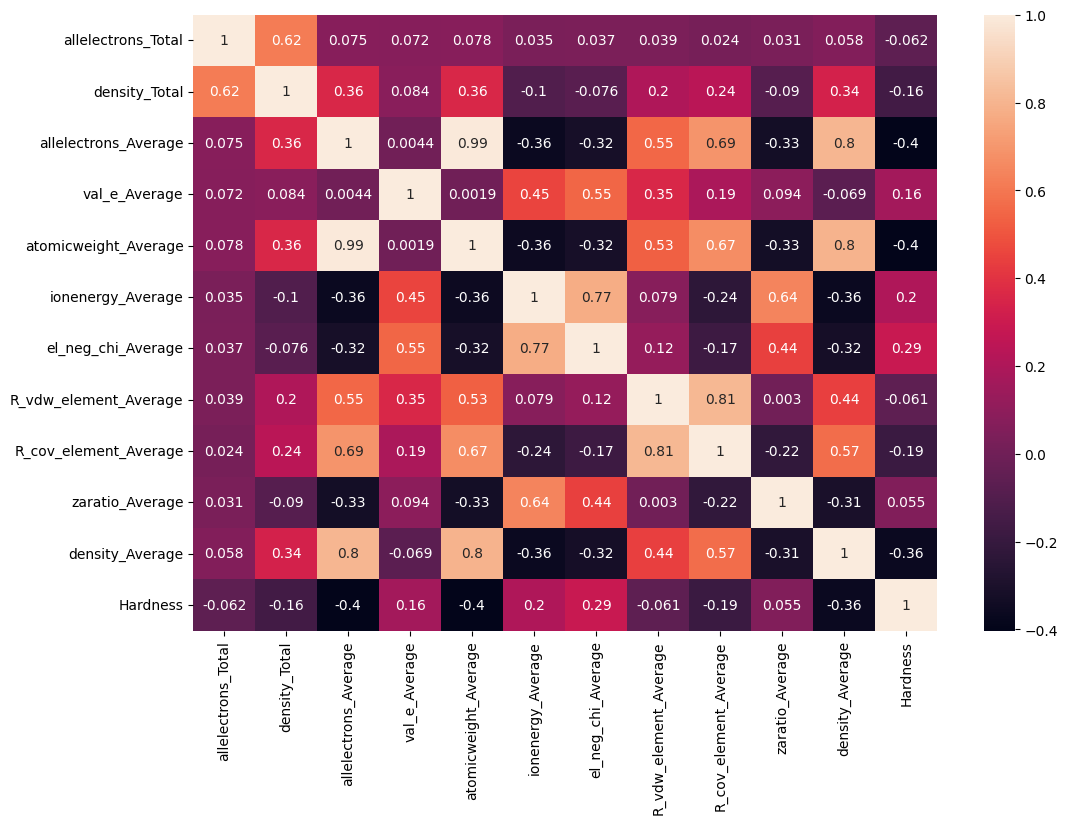

In [8]:
%matplotlib inline

plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True)
plt.show()

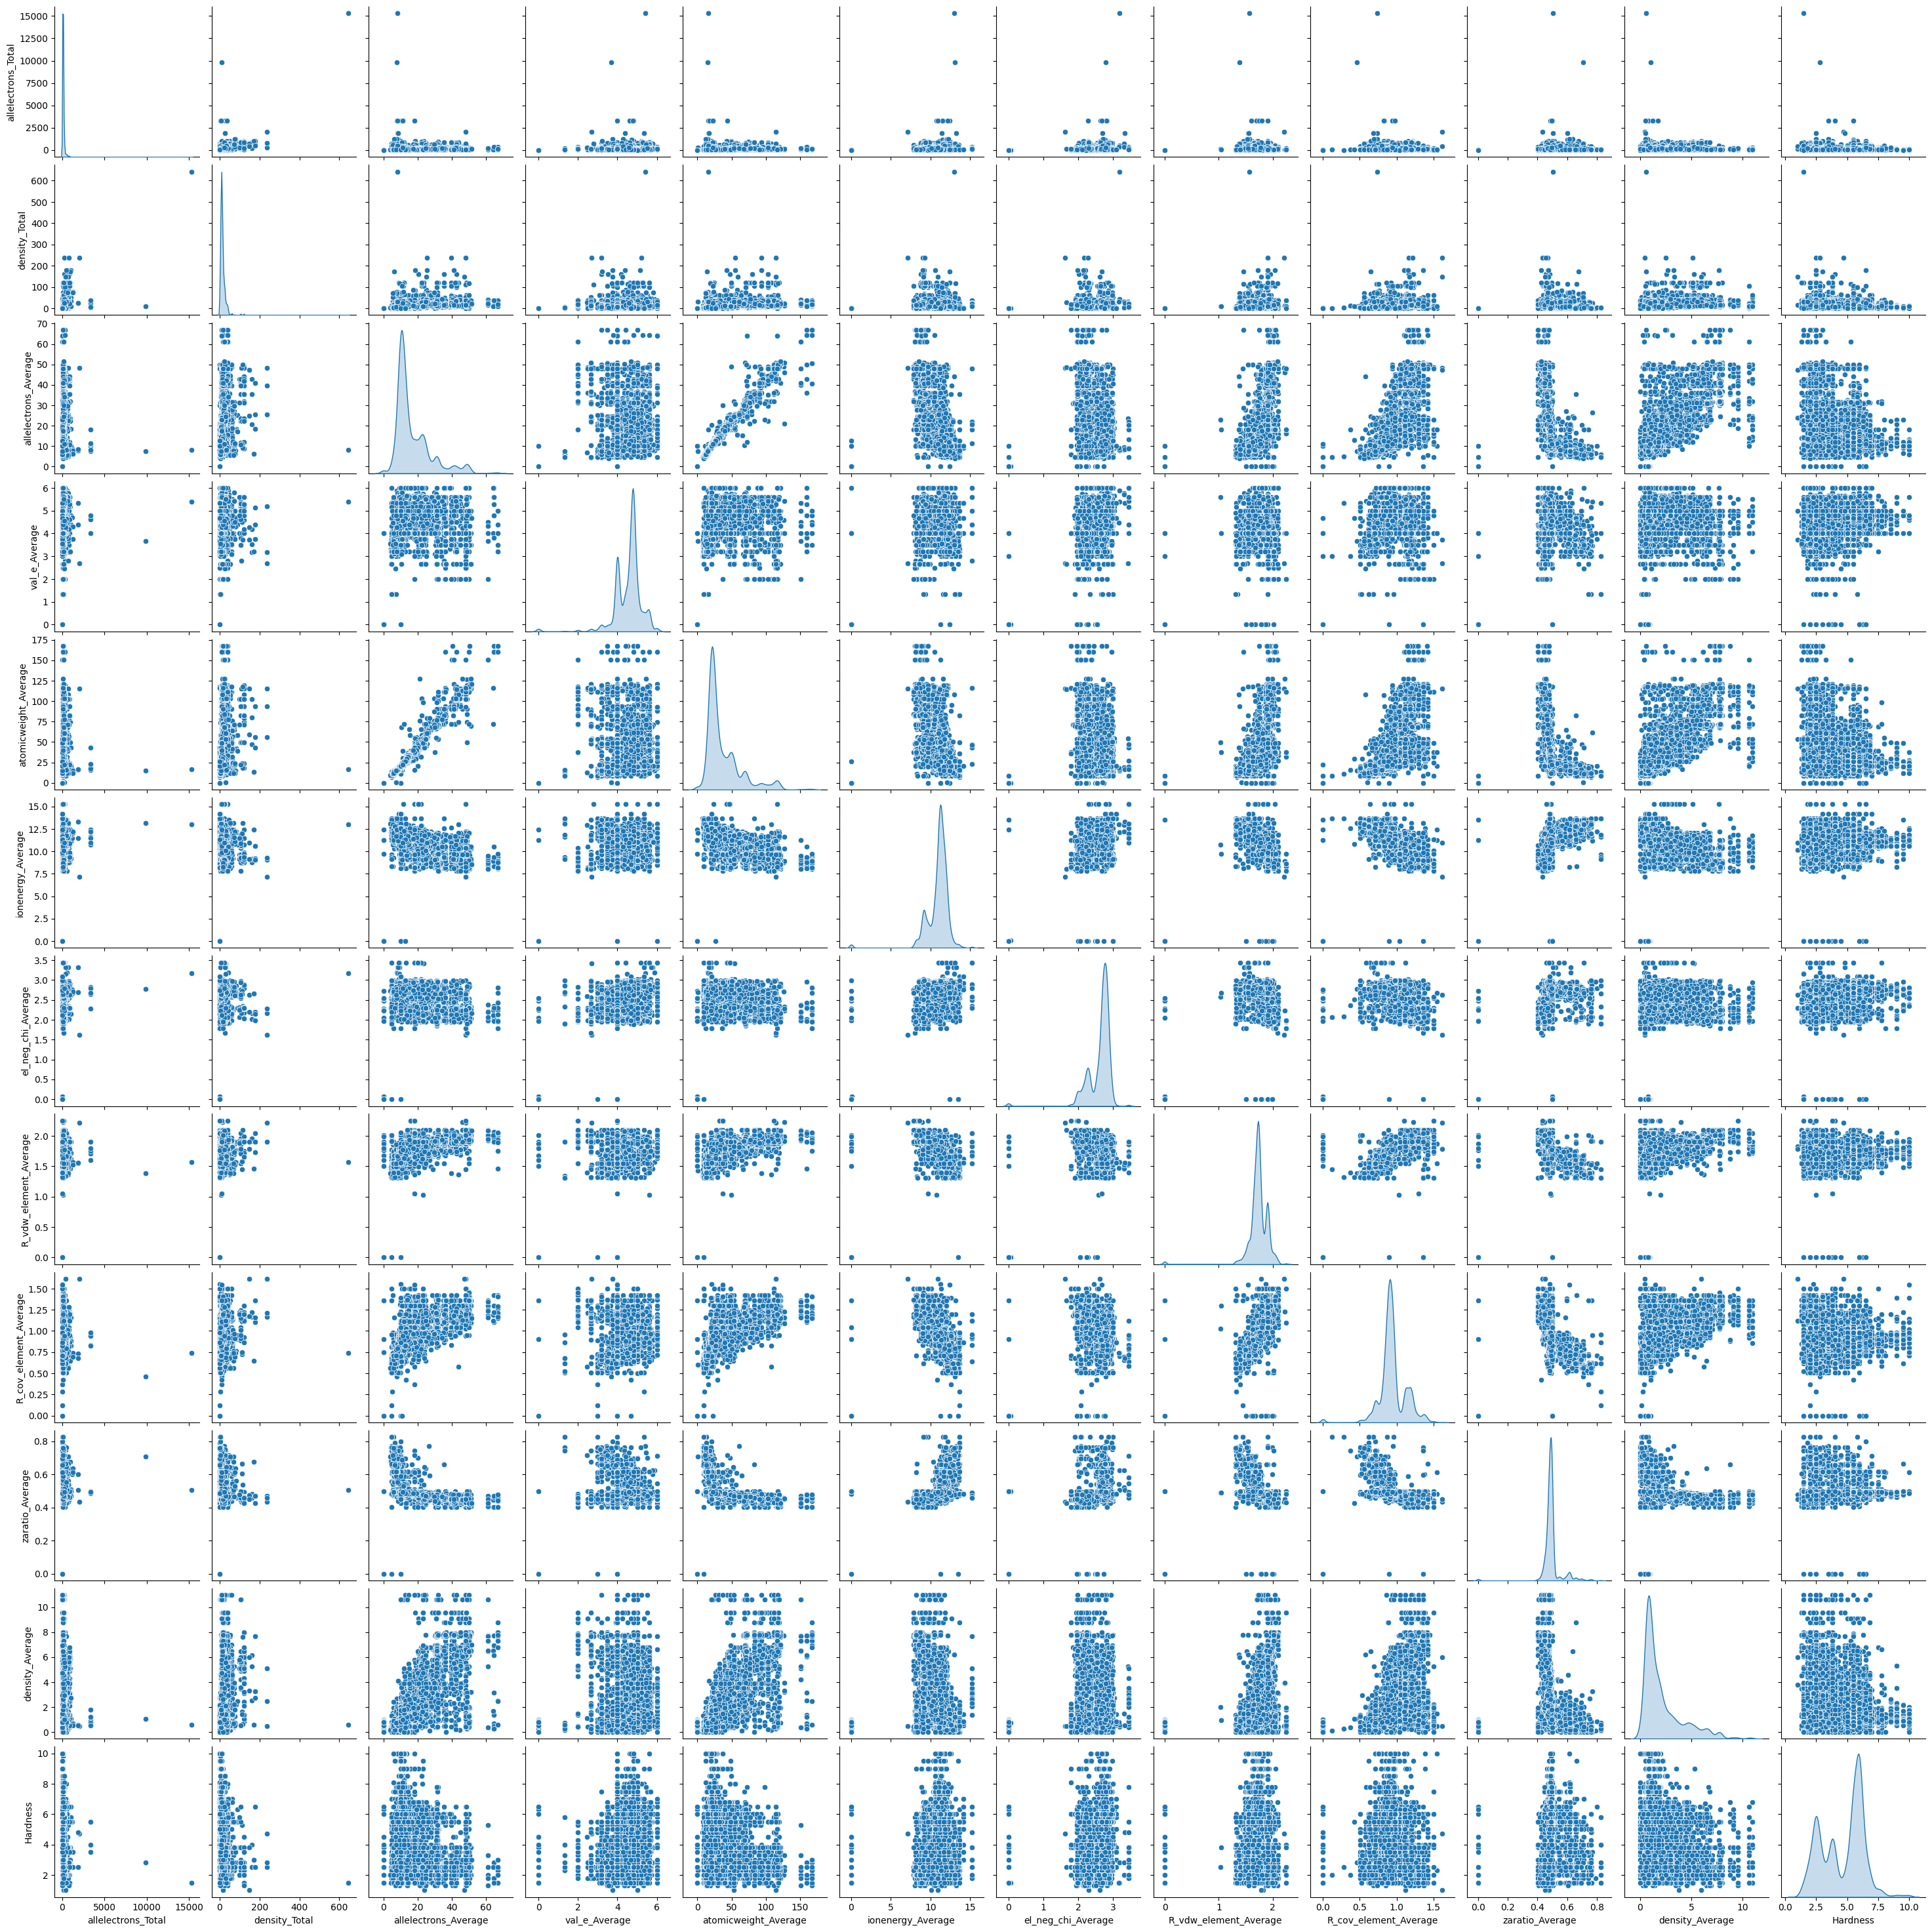

In [9]:
sns.pairplot(data=train_df.drop(columns=['id']), diag_kind='kde')

In [10]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
scaled_train_df = train_df.drop('id', axis=1)
scaled_train_df[scaled_train_df.columns] = sc.fit_transform(scaled_train_df)
scaled_train_df.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,-0.125176,-0.854598,-0.671863,0.366532,-0.649538,0.106370,0.472806,0.003480,-0.467381,0.043139,-0.629163,0.805069
1,-0.125176,-0.434060,-0.671863,0.366532,-0.661596,0.782925,0.439960,-0.521272,-0.189615,-0.009986,-0.730874,1.102609
2,-0.232265,-0.350946,-0.136912,1.524558,-0.144879,0.815215,0.657942,0.294432,-0.445159,-0.188197,-0.323591,-1.277713
3,-0.125176,-0.356625,-0.671863,0.366532,-0.664885,0.007237,0.120452,-0.547250,-0.045177,-0.064634,-0.693814,0.805069
4,-0.053783,-0.307620,-0.519020,0.366532,-0.481317,0.629290,0.472806,-0.256298,-0.267389,-0.009717,-0.138479,0.805069


In [11]:
#from sklearn.feature_selection import SelectKBest, r_regression
#X_new = SelectKBest(r_regression, k=5).fit_transform(X, y)
#pd.DataFrame(X_new).head()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:blue'` for same effect.
  warnings.warn(msg, FutureWarning)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'allelectrons_Total'),
  Text(1, 0, 'density_Total'),
  Text(2, 0, 'allelectrons_Average'),
  Text(3, 0, 'val_e_Average'),
  Text(4, 0, 'atomicweight_Average'),
  Text(5, 0, 'ionenergy_Average'),
  Text(6, 0, 'el_neg_chi_Average'),
  Text(7, 0, 'R_vdw_element_Average'),
  Text(8, 0, 'R_cov_element_Average'),
  Text(9, 0, 'zaratio_Average'),
  Text(10, 0, 'density_Average'),
  Text(11, 0, 'Hardness')])

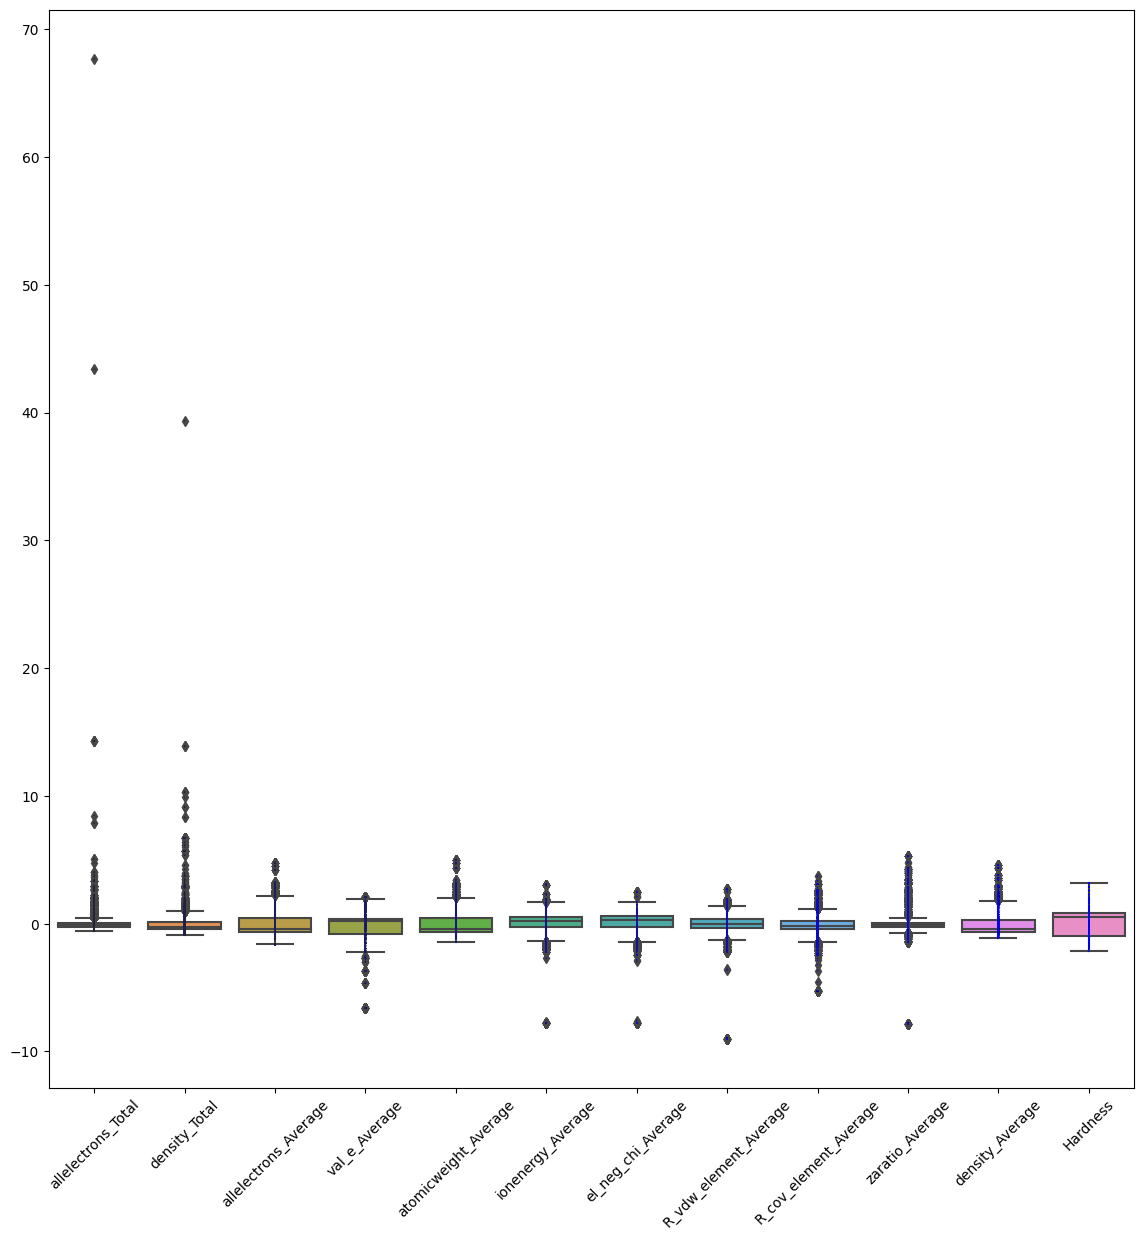

In [12]:
plt.figure(figsize=(14, 14)) 
sns.boxplot(data=scaled_train_df)
sns.stripplot(data=scaled_train_df, color='blue', size=1, jitter=False)
plt.xticks(rotation=45)

In [13]:
from sklearn.ensemble import RandomForestRegressor  
from sklearn.metrics import median_absolute_error, r2_score

X = scaled_train_df.drop(['Hardness'], axis=1)
y = train_df['Hardness']

X_sub = test_df.drop(['id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = LGBMRegressor(objective="mae", random_state=42, verbose=-1)
model.fit(X_train, y_train)

prediction = model.predict(X_test)
mae = median_absolute_error(y_test, prediction)
print(mae)
r2 = r2_score(y_test, prediction)
print(r2)

0.5183585130879127
0.41874301894595467


Now lets try remove outliers and see if this can be improved.

In [15]:
threshold = 1.5
no_outliers_df = scaled_train_df
for column in scaled_train_df.drop("Hardness", axis=1).columns:
    Q1 = no_outliers_df[column].quantile(0.25)
    Q3 = no_outliers_df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = no_outliers_df[(scaled_train_df[column] < Q1 - threshold * IQR) | (no_outliers_df[column] > Q3 + threshold * IQR)]
    #no_outliers_df.loc[outliers.index, column] = scaled_train_df[column].mean()
    no_outliers_df = no_outliers_df.drop(outliers.index)

/tmp/ipykernel_19/3237346571.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = no_outliers_df[(scaled_train_df[column] < Q1 - threshold * IQR) | (no_outliers_df[column] > Q3 + threshold * IQR)]
/tmp/ipykernel_19/3237346571.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = no_outliers_df[(scaled_train_df[column] < Q1 - threshold * IQR) | (no_outliers_df[column] > Q3 + threshold * IQR)]
/tmp/ipykernel_19/3237346571.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = no_outliers_df[(scaled_train_df[column] < Q1 - threshold * IQR) | (no_outliers_df[column] > Q3 + threshold * IQR)]
/tmp/ipykernel_19/3237346571.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  outliers = no_outliers_df[(scaled_train_df[column] < Q1 - threshold * IQR) | (no_outliers_df[column] > Q3 + threshold * IQR)]
/tmp/ipykernel_19/3237346571.py:7: UserWarni

In [16]:
correlations = no_outliers_df.corr()
print(correlations["Hardness"])

allelectrons_Total      -0.061120
density_Total           -0.044069
allelectrons_Average    -0.166490
val_e_Average           -0.095777
atomicweight_Average    -0.172885
ionenergy_Average       -0.252465
el_neg_chi_Average      -0.117426
R_vdw_element_Average    0.052011
R_cov_element_Average    0.004986
zaratio_Average          0.168452
density_Average         -0.098626
Hardness                 1.000000
Name: Hardness, dtype: float64


In [17]:
features = ["density_Total", "allelectrons_Average", "val_e_Average", "el_neg_chi_Average", "R_cov_element_Average","ionenergy_Average", "zaratio_Average"]

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:blue'` for same effect.
  warnings.warn(msg, FutureWarning)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'allelectrons_Total'),
  Text(1, 0, 'density_Total'),
  Text(2, 0, 'allelectrons_Average'),
  Text(3, 0, 'val_e_Average'),
  Text(4, 0, 'atomicweight_Average'),
  Text(5, 0, 'ionenergy_Average'),
  Text(6, 0, 'el_neg_chi_Average'),
  Text(7, 0, 'R_vdw_element_Average'),
  Text(8, 0, 'R_cov_element_Average'),
  Text(9, 0, 'zaratio_Average'),
  Text(10, 0, 'density_Average')])

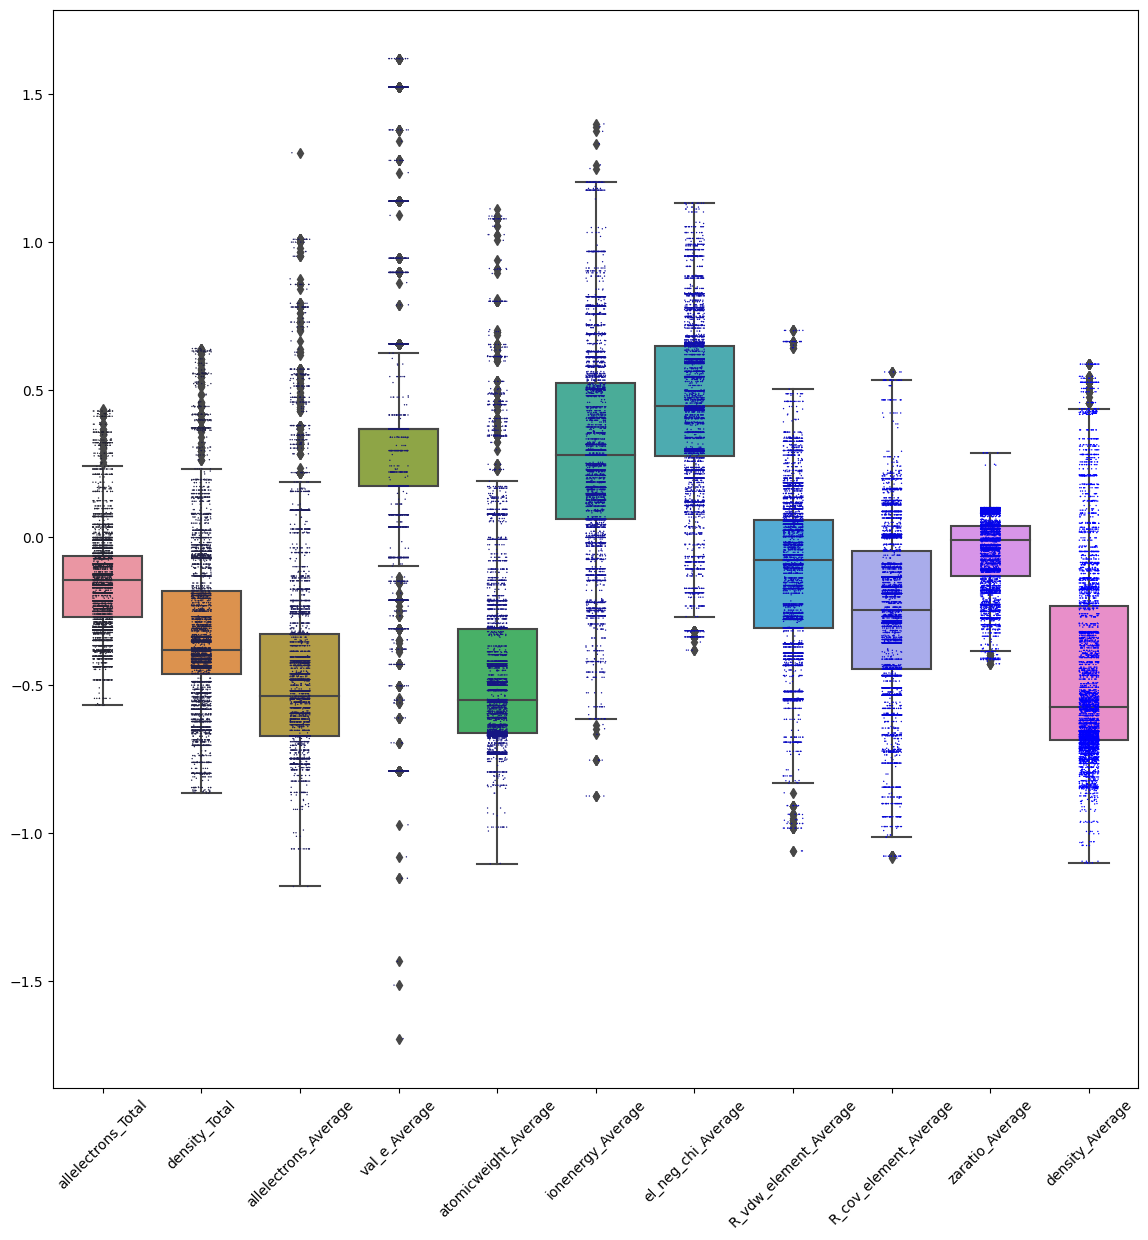

In [18]:
plt.figure(figsize=(14, 14)) 
sns.boxplot(data=no_outliers_df.drop("Hardness", axis=1))
sns.stripplot(data=no_outliers_df.drop("Hardness", axis=1), color='blue', size=1, jitter=True)
plt.xticks(rotation=45)

In [19]:
X = train_df.drop(["Hardness", "id"], axis=1)
#X = X[features]
y = train_df["Hardness"]#.drop(outliers.index)
print(X.shape[0])
print(y.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

10407
10407


In [20]:
model2 = LGBMRegressor(objective="mae", random_state=42, verbose=-1)
model2.fit(X_train, y_train)
prediction = model.predict(X_test)
mae = median_absolute_error(y_test, prediction)
print(mae)
r2 = r2_score(y_test, prediction)
print(r2)

2.5505291429855745
-1.1221951233971033


Make submission predictions

In [21]:
sub_pred = model.predict(sc.fit_transform(X_sub))

sub_df = pd.DataFrame(test_df['id'])
sub_df['Hardness'] = pd.DataFrame(sub_pred)[0]
sub_df.head(10)

,id,Hardness
0,10407,2.941033
1,10408,2.894926
2,10409,5.765966
3,10410,4.226679
4,10411,5.078945
5,10412,5.602119
6,10413,4.223857
7,10414,5.259840
8,10415,3.382203
9,10416,5.045293


In [22]:
sub_df.to_csv('submission.csv', index = False)